In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append('../../src')

In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

### Run COVET

In [3]:
adata.layers['log'] = adata.layers['normalized_count'].copy()
adata.X = adata.layers['log']

In [4]:
import scenvi 

st_data = adata
st_data.obsm['COVET'], st_data.obsm['COVET_SQRT'], st_data.uns['CovGenes'] = scenvi.compute_covet(st_data)

In [6]:
outdir = '/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_kidney_13'

np.save(outdir + '/COVET.npy', st_data.obsm['COVET'])
np.save(outdir + '/COVET_SQRT.npy', st_data.obsm['COVET_SQRT'])

In [8]:
%matplotlib inline
import sys
sys.path.append('../../src')
from covet.utils import *

st_data_sst = st_data

FDL_COVET = np.asarray(FDL(flatten(st_data_sst.obsm['COVET_SQRT']), k = 30))
st_data_sst.obsm['FDL_COVET'] = FDL_COVET

100%|██████████| 500/500 [00:48<00:00, 10.25it/s]

BarnesHut Approximation  took  27.29  seconds
Repulsion forces  took  19.12  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.92  seconds
AdjustSpeedAndApplyForces step  took  0.60  seconds


In [ ]:
# DC_COVET = np.asarray(run_diffusion_maps(flatten(st_data_sst.obsm['COVET_SQRT']), knn = 30)['EigenVectors'])[:, 1:]
# st_data_sst.obsm['DC_COVET'] = -DC_COVET

In [ ]:
# np.save(outdir + '/FDL_COVET.npy', FDL_COVET)
# np.save(outdir + '/DC_COVET.npy', DC_COVET)

### Train model with COVET feature maps

In [109]:
import pandas as pd
from spaceoracle.tools.network import RegulatoryFactory
from spaceoracle.gene_factory import GeneFactory
from spaceoracle.astronomer import Astronaut


base_dir = '/ix/djishnu/shared/djishnu_kor11/'

co_grn = RegulatoryFactory(
    colinks_path=base_dir + 'training_data_2025/mouse_kidney_13_colinks.pkl',
    annot='cell_type_int'
)

In [5]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [ ]:
sp_maps = np.load('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_kidney_13/COVET_SQRT.npy')
feature_key = 'COVET_SQRT'
adata.obsm['COVET_SQRT'] = sp_maps

In [111]:
sp_maps = np.load('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_kidney_13/COVET.npy')
feature_key = 'COVET'
adata.obsm['COVET'] = sp_maps

In [112]:
cell_threshes = pd.read_parquet(
    base_dir + 'training_data_2025/mouse_kidney_13_LRs.parquet')
adata.uns['cell_thresholds'] = cell_threshes

print(adata)

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled', 'COVET_SQRT', 'COVET'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'


In [114]:
from spaceoracle.models.adapted_estimators import PrefeaturizedCellularProgramsEstimator

target_gene = 'Hist1h2ac'

estimator = PrefeaturizedCellularProgramsEstimator(
    adata, target_gene=target_gene, cluster_annot='cell_type_int',
    radius=100, contact_distance=30, grn=co_grn, 
    sp_maps_key='COVET')

estimator.fit(
    num_epochs=200, 
    learning_rate=5e-3, 
    score_threshold=0.2,
    estimator='lasso',
    # use_anchors=False
)


Using COVET as spatial maps


Fitting Hist1h2ac with 354 modulators
	10 Transcription Factors
	326 Ligand-Receptor Pairs
	18 TranscriptionFactor-Ligand Pairs
0: 0.9875 | 0.7122
1: 0.9720 | 0.6682
2: 0.9983 | 0.9203
3: 0.9990 | 0.8475
4: 0.8490 | 0.4362
5: 0.9972 | 0.9436
6: 0.9922 | 0.7688


In [113]:
neil = Astronaut(
    adata=adata,
    annot='cell_type_int', 
    max_epochs=100, 
    learning_rate=5e-4, 
    spatial_dim=64,
    batch_size=512,
    grn=co_grn,
    radius=100,
    contact_distance=30,
    save_dir=base_dir + 'covet_runs/mouse_kidney_13'
)


In [ ]:
neil.run()

### Compare COVET and CNN betas

In [5]:
covet_betadir = '/ix/djishnu/shared/djishnu_kor11/covet_runs/mouse_kidney_13'
cnn_betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13'

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Pandas doesn't allow columns to be created via a new attribute name.*")

In [73]:
from spaceoracle.prophets import Prophet

cnn_prophet = Prophet(adata, models_dir=cnn_betadir)
cnn_prophet.compute_betas(subsample=600)

In [74]:
covet_prophet = Prophet(adata, models_dir=covet_betadir)
covet_prophet.compute_betas(subsample=600)

In [75]:
targets = set(covet_prophet.beta_dict.data.keys()) & set(cnn_prophet.beta_dict.data.keys())
targets

{'Arhgap23',
 'Atp6v1g3',
 'Fbxl12os',
 'Hepacam2',
 'Hist1h2ac',
 'Hist1h2br',
 'Hist2h2bb',
 'Hs3st3a1',
 'Pdcd1lg2',
 'Ppargc1a',
 'Ppp1r16b',
 'Rabgap1l',
 'Ralgapa2',
 'Rasgef1b',
 'Serpinf2',
 'Slc22a18',
 'Slc25a33',
 'Slc39a11',
 'Tmem150c',
 'Tnfrsf13b',
 'Tnfrsf13c',
 'Vkorc1l1'}

In [77]:
[x for x in covet_prophet.beta_dict.data['Hist1h2ac'].columns if 'Mif' in x]

['beta_Mif$Cd74',
 'beta_Mif$Cxcr4',
 'beta_Mif$Cd44',
 'beta_Mif$Cxcr2',
 'beta_Mif$Ackr3']

In [127]:
target_gene = 'Hist1h2ac'
regulator = 'beta_Mif$Cxcr4'

cnn_betas = cnn_prophet.beta_dict.data[target_gene]
modulator_order = cnn_betas.columns

# covet_betas = covet_prophet.beta_dict.data[target_gene][modulator_order]
covet_betas = estimator.betadata[modulator_order].copy()

In [128]:
diff_betas = cnn_betas - covet_betas
diff_betas.head(3)

beta0  beta_Ahr  beta_Atf3  beta_Bhlhe40  beta_E2f3  \
Hist1h2ac                                                                     
AAACCCAAGAGGGTCT-13  0.014249 -0.049952   0.000220      0.020999  -0.034411   
AAACCCAAGCGTGTTT-13  0.001821 -0.007465   0.078823     -0.000842  -0.015172   
AAACCCAAGGTGATAT-13  0.002315  0.065780   0.000874      0.016560   0.022102   

                     beta_Egr1  beta_Hes1  beta_Hnf4a  beta_Mbd1  beta_Pax5  \
Hist1h2ac                                                                     
AAACCCAAGAGGGTCT-13  -0.006291  -0.001146   -0.021109   0.006368   0.021538   
AAACCCAAGCGTGTTT-13  -0.000167  -0.003889    0.001467  -0.018473   0.000550   
AAACCCAAGGTGATAT-13  -0.030680  -0.000337    0.069527   0.007580  -0.041446   

                     ...  beta_Cd6#E2f3  beta_Bmp2#Hes1  beta_Egf#Hes1  \
Hist1h2ac            ...                                                 
AAACCCAAGAGGGTCT-13  ...            0.0        0.000068       0.000017   
AAACCCAAGCGTGTTT-13  ...            0.0        0.000000       0.000000   
AAACCCAAGGTGATAT-13  ...            0.0        0.000100       0.000009   

                     beta_Vegfa#Hes1  beta_Pdgfd#Hes1  beta_Igf1#Hnf4a  \
Hist1h2ac                                                                
AAACCCAAGAGGGTCT-13         0.000018         0.000241        -0.000078   
AAACCCAAGCGTGTTT-13        -0.000000         0.000000         0.000000   
AAACCCAAGGTGATAT-13         0.000019         0.000105        -0.000118   

                     beta_Tgfb2#Hnf4a  beta_Il27#Mbd1  beta_Cd6#Mbd1  \
Hist1h2ac                                                              
AAACCCAAGAGGGTCT-13               0.0        0.000006            0.0   
AAACCCAAGCGTGTTT-13               0.0        0.000000            0.0   
AAACCCAAGGTGATAT-13               0.0        0.000005            0.0   

                     beta_Il27#Sp4  
Hist1h2ac                           
AAACCCAAGAGGGTCT-13       0.000012  
AAACCCAAGCGTGTTT-13       0.000000  
AAACCCAAGGTGATAT-13       0.000017  

[3 rows x 355 columns]

In [129]:
ct_masks = {ct: adata.obs['cell_type'] == ct for ct in adata.obs['cell_type'].unique()}

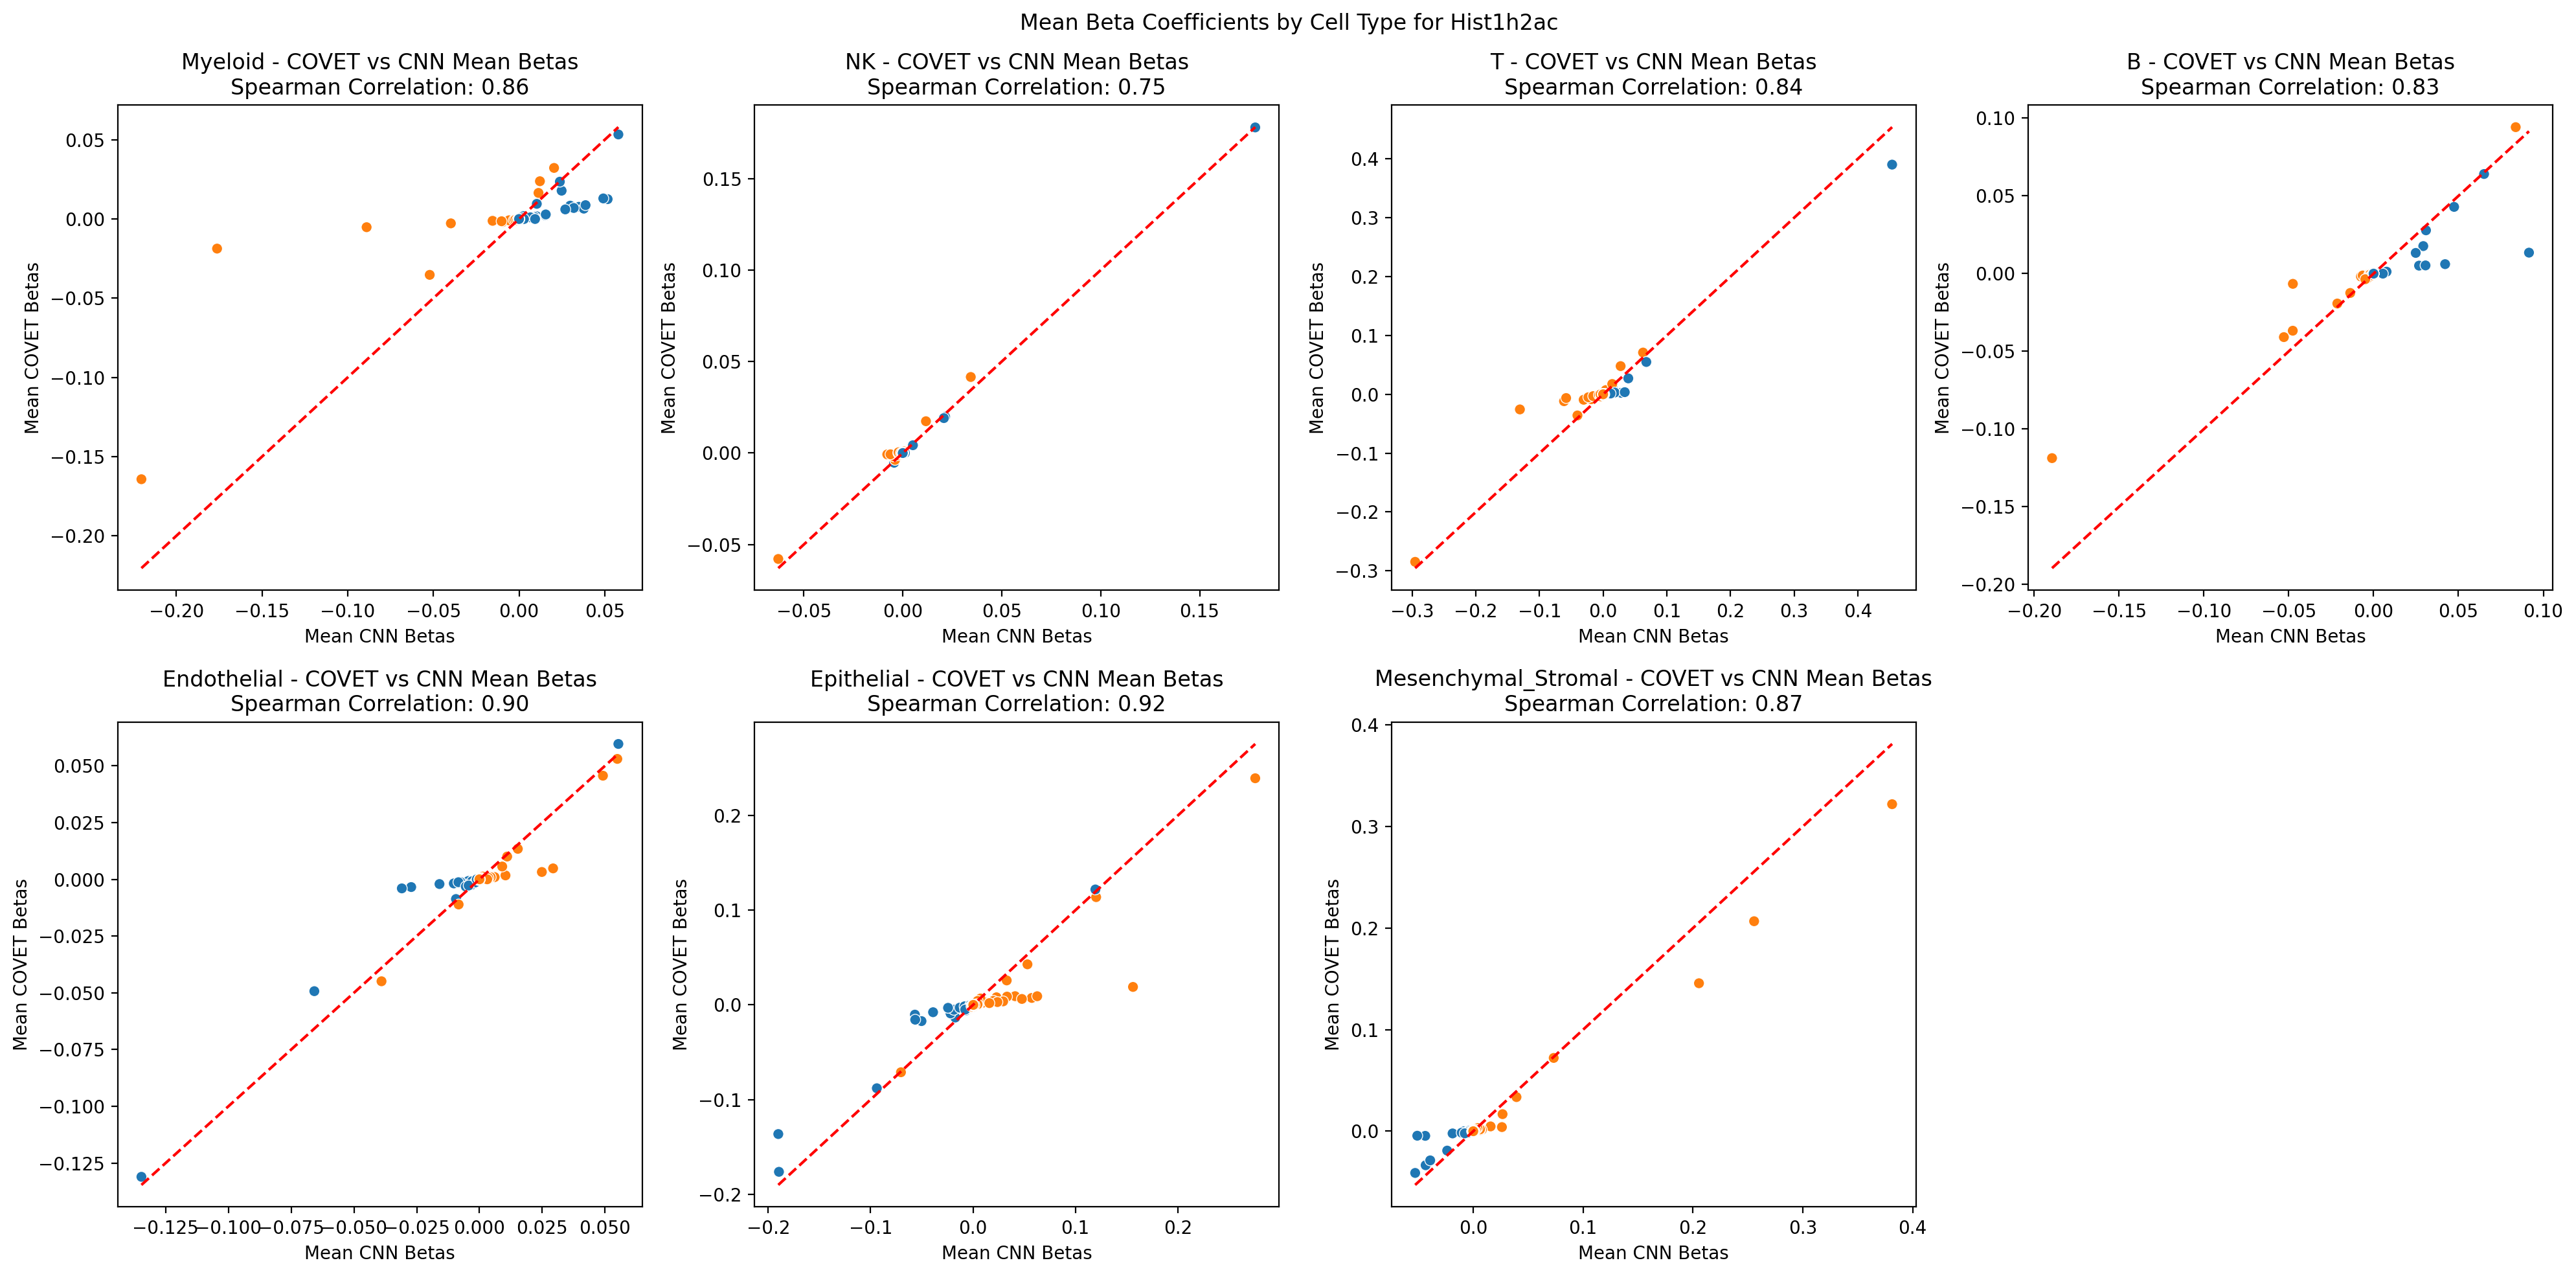

In [130]:
cell_types = list(ct_masks.keys())
nrows = (len(cell_types) + 2) // 4  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(20, 5 * nrows))

for ax, cell_type in zip(axes.flat, cell_types):
    masked_cnn_betas = cnn_betas.loc[ct_masks[cell_type]]
    masked_covet_betas = covet_betas.loc[ct_masks[cell_type]]
    corr = masked_cnn_betas.mean(axis=0).corr(masked_covet_betas.mean(axis=0), method='spearman')

    mean_cnn_betas = masked_cnn_betas.mean(axis=0)
    mean_covet_betas = masked_covet_betas.mean(axis=0)
    colors = list(np.where(mean_covet_betas > mean_cnn_betas, 'green', 'blue'))

    sns.scatterplot(x=mean_cnn_betas, y=mean_covet_betas, ax=ax, hue=colors, legend=False)
    ax.plot([mean_cnn_betas.min(), mean_cnn_betas.max()],
            [mean_cnn_betas.min(), mean_cnn_betas.max()],
            'r--')
    ax.set_xlabel('Mean CNN Betas')
    ax.set_ylabel('Mean COVET Betas')
    ax.set_title(f'{cell_type} - COVET vs CNN Mean Betas\nSpearman Correlation: {corr:.2f}')

for ax in axes.flat[len(cell_types):]:
    ax.set_visible(False)

plt.suptitle(f'Mean Beta Coefficients by Cell Type for {target_gene}')
plt.tight_layout()
plt.show()


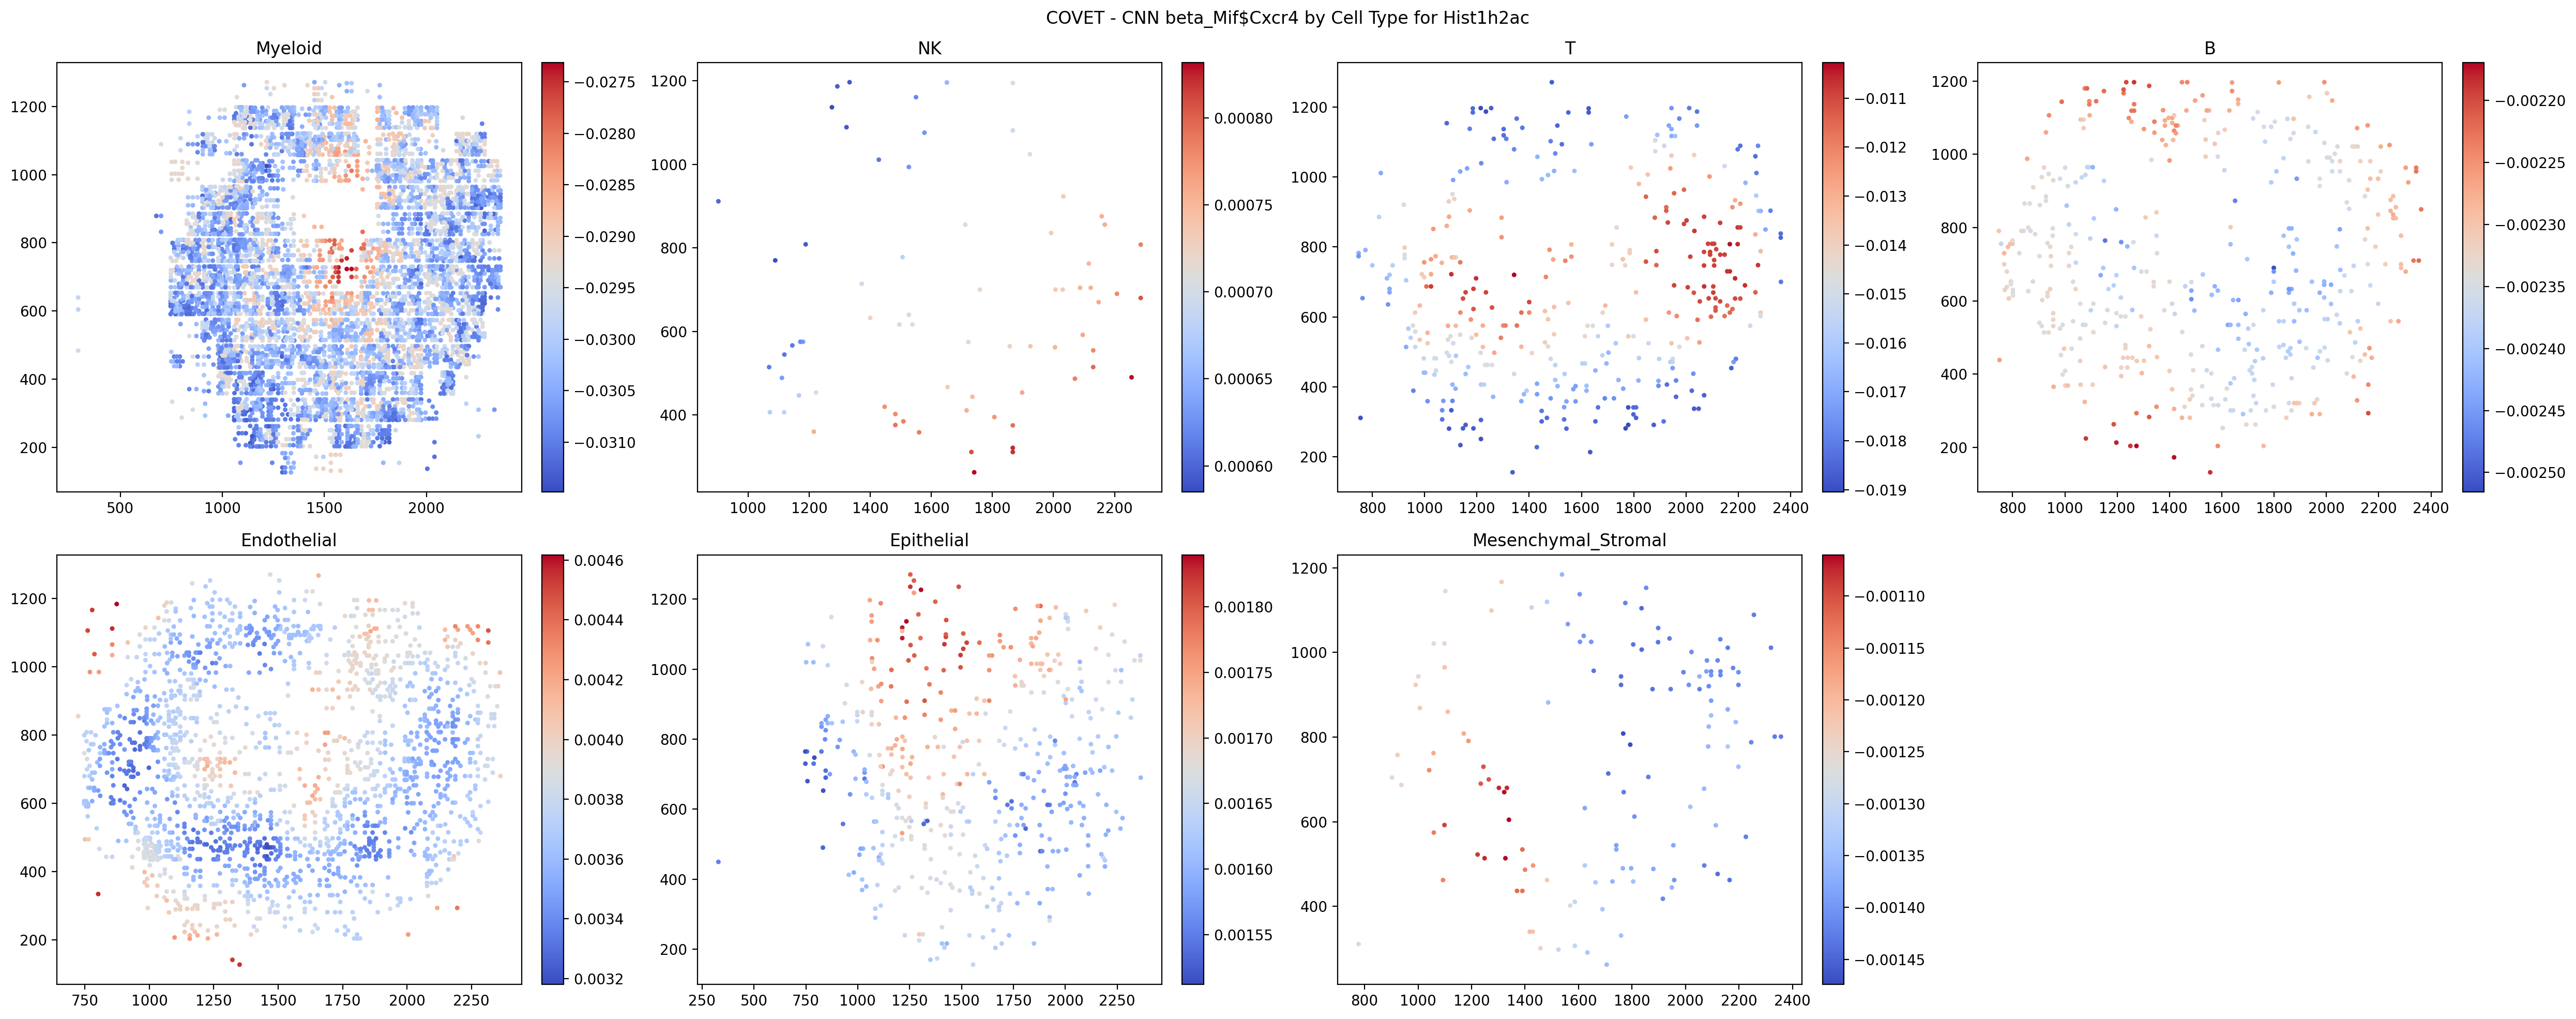

In [131]:
cell_types = list(ct_masks.keys())
nrows = (len(cell_types) + 2) // 4  

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 5 * nrows))

for ax, cell_type in zip(axes.flat, cell_types):
    masked_cnn_betas = cnn_betas.loc[ct_masks[cell_type], regulator]
    masked_covet_betas = covet_betas.loc[ct_masks[cell_type], regulator]

    colors = masked_covet_betas - masked_cnn_betas

    scatter = ax.scatter(x=adata[ct_masks[cell_type], :].obsm['spatial'][:, 0], 
                         y=adata[ct_masks[cell_type], :].obsm['spatial'][:, 1], 
                         c=colors, s=5, cmap='coolwarm')
    ax.set_title(f'{cell_type}')
    fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for ax in axes.flat[len(cell_types):]:
    ax.set_visible(False)

plt.suptitle(f'COVET - CNN {regulator} by Cell Type for {target_gene}')
plt.tight_layout()
plt.show()


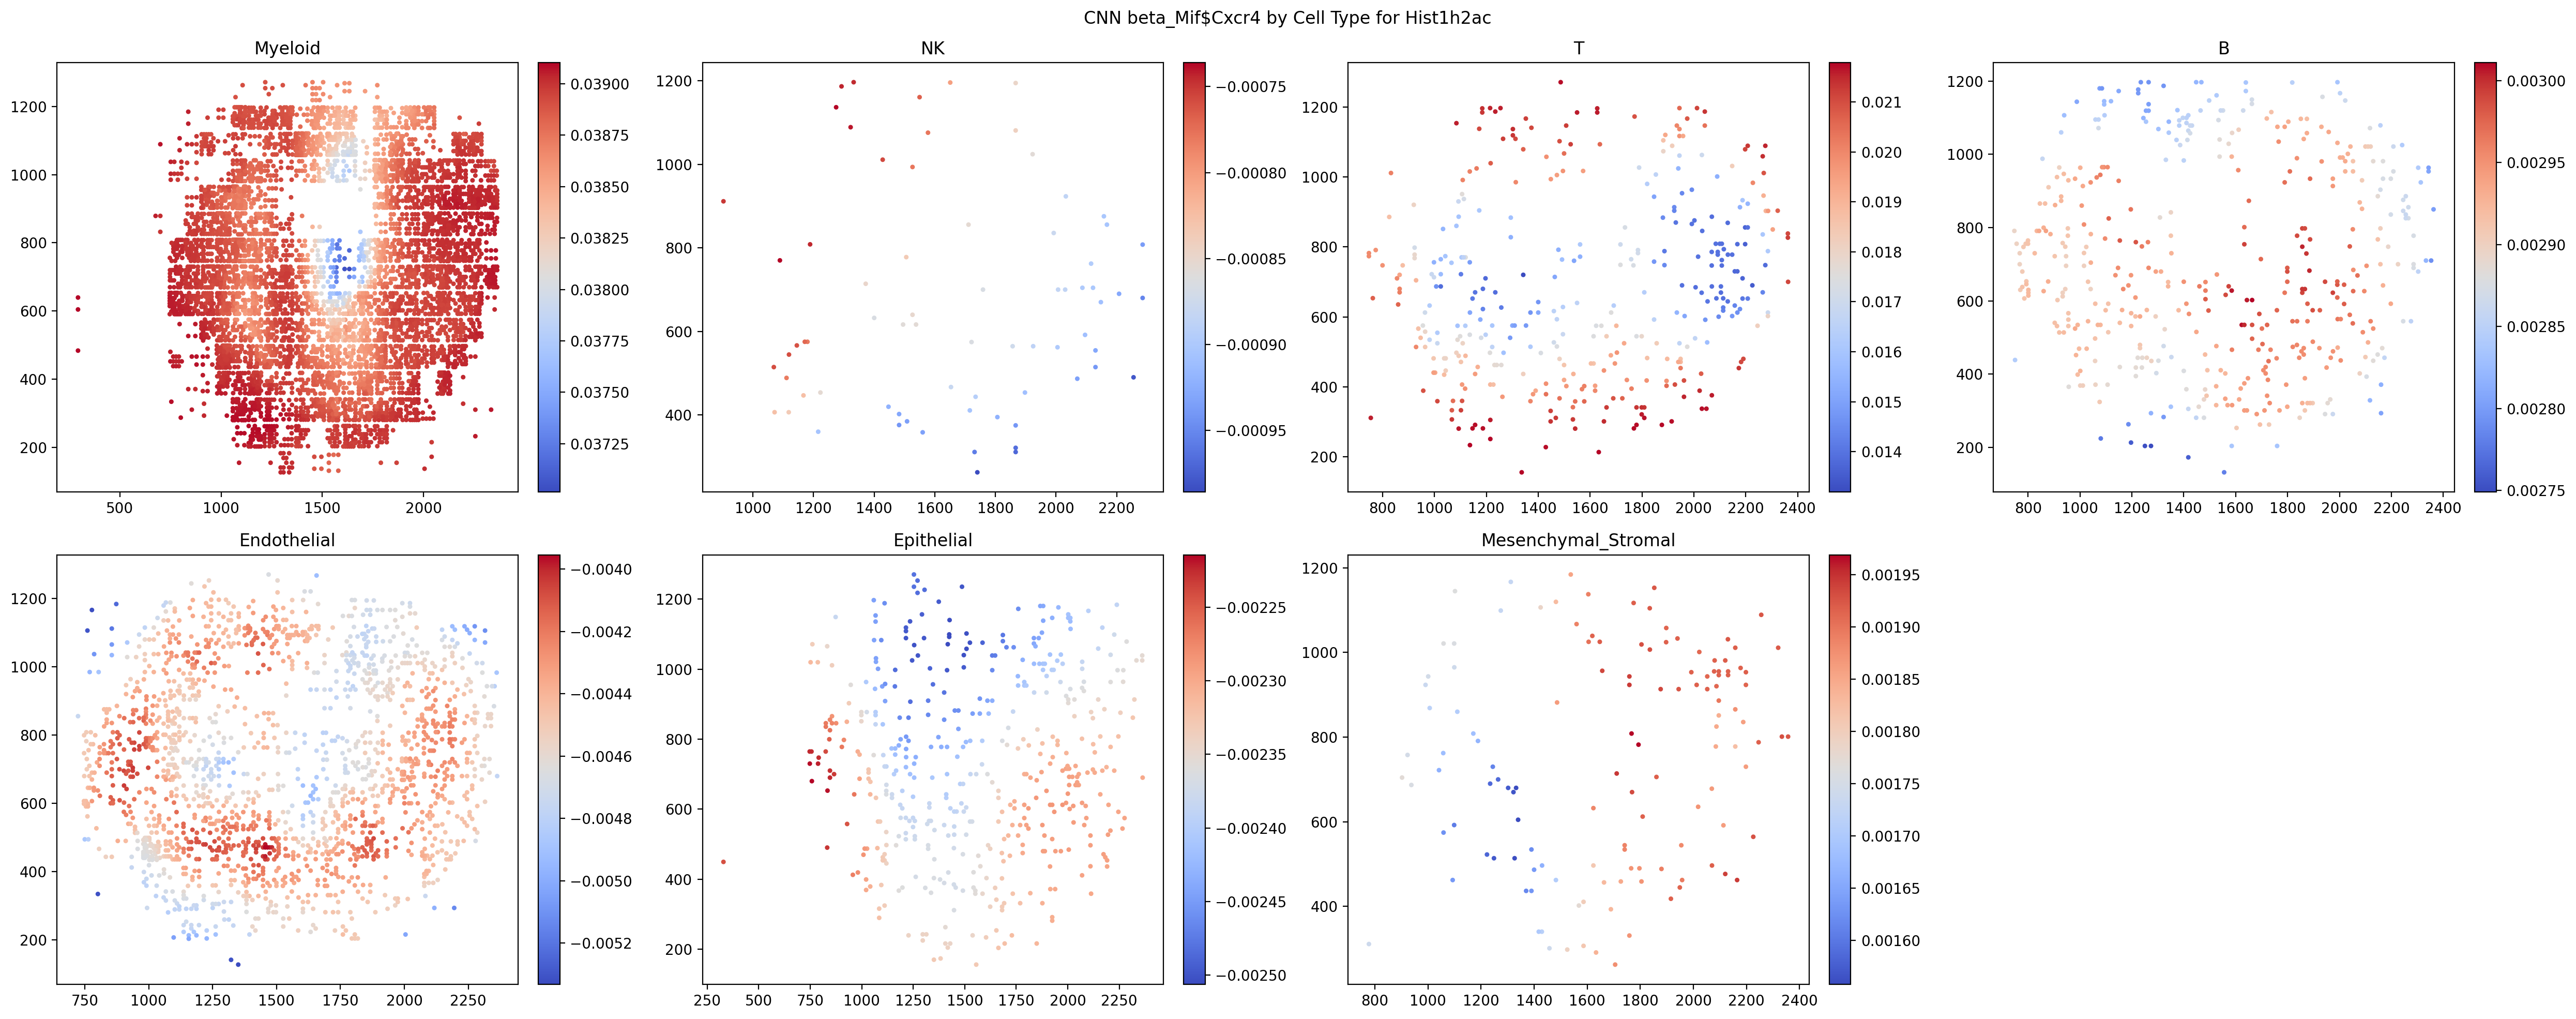

In [132]:
cell_types = list(ct_masks.keys())
nrows = (len(cell_types) + 2) // 4  

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 5 * nrows))

for ax, cell_type in zip(axes.flat, cell_types):
    masked_cnn_betas = cnn_betas.loc[ct_masks[cell_type], regulator]
    colors = masked_cnn_betas

    scatter = ax.scatter(x=adata[ct_masks[cell_type], :].obsm['spatial'][:, 0], 
                         y=adata[ct_masks[cell_type], :].obsm['spatial'][:, 1], 
                         c=colors, s=5, cmap='coolwarm')
    ax.set_title(f'{cell_type}')
    fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for ax in axes.flat[len(cell_types):]:
    ax.set_visible(False)

plt.suptitle(f'CNN {regulator} by Cell Type for {target_gene}')
plt.tight_layout()
plt.show()


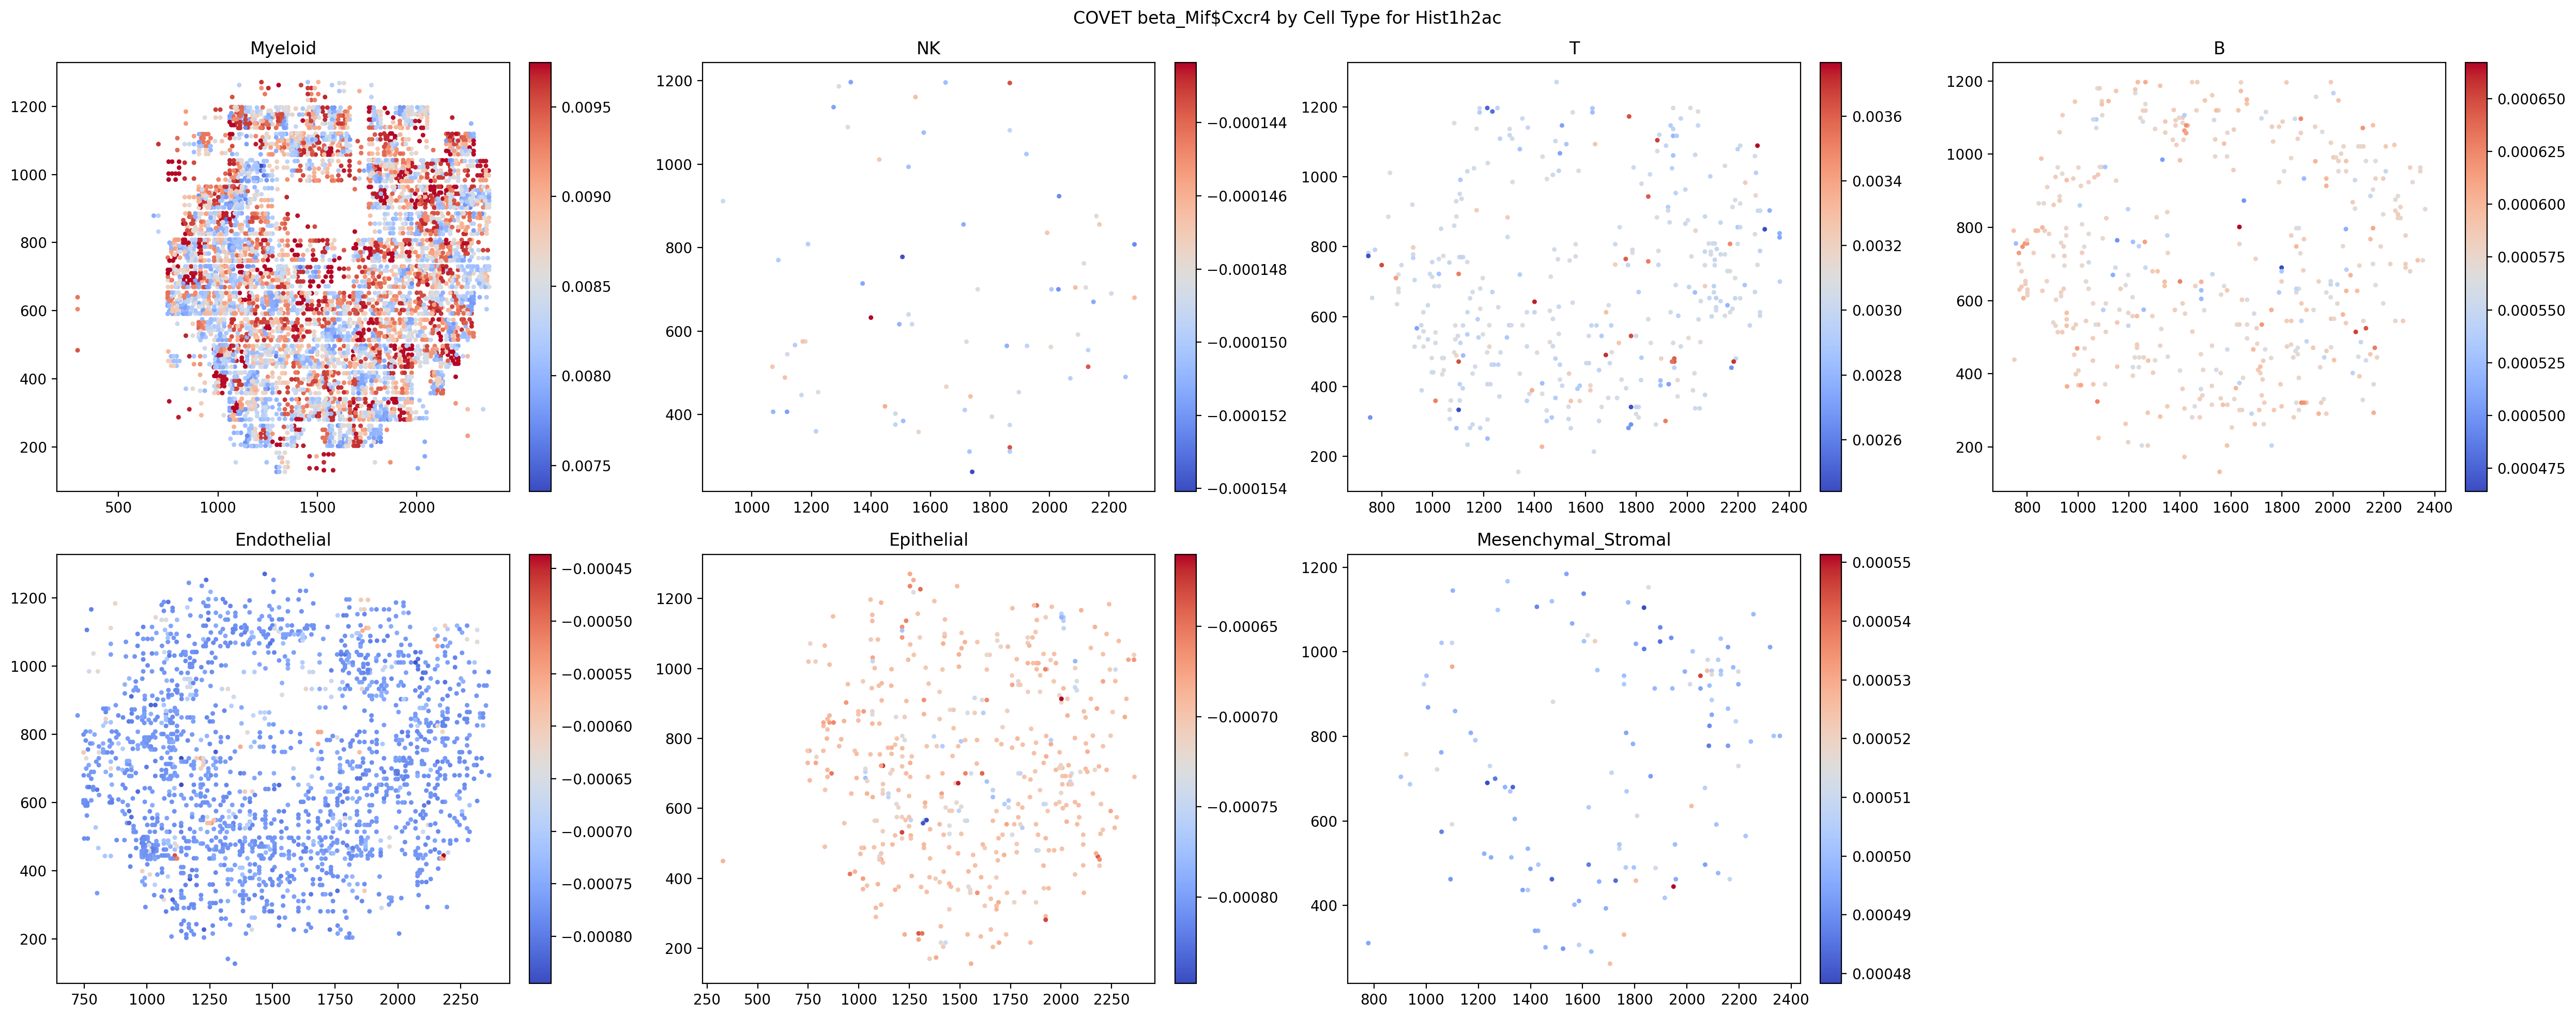

In [133]:
cell_types = list(ct_masks.keys())
nrows = (len(cell_types) + 2) // 4  

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 5 * nrows))

for ax, cell_type in zip(axes.flat, cell_types):
    masked_covet_betas = covet_betas.loc[ct_masks[cell_type], regulator]
    colors = masked_covet_betas

    scatter = ax.scatter(x=adata[ct_masks[cell_type], :].obsm['spatial'][:, 0], 
                         y=adata[ct_masks[cell_type], :].obsm['spatial'][:, 1], 
                         c=colors, s=5, cmap='coolwarm')
    ax.set_title(f'{cell_type}')
    fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for ax in axes.flat[len(cell_types):]:
    ax.set_visible(False)

plt.suptitle(f'COVET {regulator} by Cell Type for {target_gene}')
plt.tight_layout()
plt.show()


### Compare perturbations

In [7]:
covet_betadir = '/ix/djishnu/shared/djishnu_kor11/covet_runs/mouse_kidney_13'
cnn_betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13'

In [ ]:
gf = GeneFactory.from_json(
    adata=adata, 
    json_path='/ix/djishnu/shared/djishnu_kor11/covet_runs/mouse_kidney_13' + '/run_params.json', 
)
gf.load_betas()

gf.perturb(target='Mif', n_propagation=4, save_layer=True)
pd.DataFrame(
    gf.adata.layers['Mif_4n_0x'],
    index=gf.adata.obs_names,
    columns=gf.adata.var_names
).to_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13_COVET/Mif_4n_0x.parquet')


In [ ]:
mif_df = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13_COVET/Mif_4n_0x.parquet')
adata.layers['Mif_4n_0x'] = mif_df.values

In [ ]:
colors = ["#496752",
"#c444d6",
"#61e242",
"#673dce",
"#b7e937",
"#3c227f",
"#cfd543",
"#566eda",
"#96e166",
"#db3c9d",
"#5cde7b",
"#862d86",
"#5ba833",
"#a06dd9",
"#d7aa2e",
"#62579b",
"#c5dc83",
"#381843",
"#74dda7",
"#dd4529",
"#60e0d7",
"#db415c",
"#4a924e",
"#d777d1",
"#6d7e2c",
"#688cd1",
"#d27835",
"#57b3d6",
"#92332a",
"#a7d1d6",
"#571e27",
"#d0dbb5",
"#883665",
"#cfad64",
"#42456f",
"#d48370",
"#282b36",
"#d66589",
"#539d8b",
"#ca8fc3",
"#2a431d",
"#b9b4db",
"#4e3821",
"#dbafab",
"#4f7389",
"#88622f",
"#8f6570",
"#979972"]

color_dict = {
    ct: color for ct, color in zip(test_adata.obs['ct3'].unique(), colors)
}

# for ct in adata.obs['ct3'].unique():
#     if ct not in chart.color_dict.keys():
#         chart.color_dict[ct] = '#808080'

In [ ]:
target_gene = 'Mif'
chart = Cartography(adata, color_dict)

In [ ]:
xy = pd.DataFrame(adata.obsm['spatial'], columns=['x', 'y'], index=adata.obs_names)
df = xy.join(adata.obs).join(adata.to_df(layer='imputed_count'))
df = df[df.x > 500]
splat = gf.splash_betas(target_gene)
bdf = splat.join(xy).join(adata.obs)
df_ = bdf[bdf['ct3'].isin(['Mac_3_TGFB3+', 'Mac_0', 'Mac_2'])]
df_ = df_[df_.x > 500]

top_betas = splat.mean().sort_values(ascending=False, key=abs).head(12)
top_betas

In [ ]:
ref_order = [
    'beta_Tfcp2l1', 'beta_Mbd1', 'beta_Gata3', 'beta_Pax2', 'beta_Sp4', 'beta_Id4', 
    'beta_Sim2', 'beta_Klf5', 'beta_Tead1', 'beta_Jdp2', 'beta_Bhlhe40', 'beta_Sim1'
]

fig, axes = plt.subplots(4, 3, figsize=(25, 19), dpi=200)
axes = axes.flatten()

for i, target in enumerate(ref_order):
    ax = axes[i]
    
    ax.scatter(
        df['x'], df['y'],
        c='grey',
        alpha=0.3,
        s=20, marker='o',
        cmap='rainbow',
        linewidth=0.0, edgecolor='black'
    )

    markers = {'Mac_3_TGFB3+': 'o', 'Mac_0': 'X', 'Mac_2': 'o'}
    for cell_type in markers:
        mask = df_['ct3'] == cell_type
        scatter = ax.scatter(
            df_[mask]['x'], df_[mask]['y'],
            c=df_[mask][target],
            s=40, marker=markers[cell_type],
            cmap='rainbow', linewidth=0.35, edgecolor='black',
        )
    
    ax.set_axis_off()
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    # cbar.set_label(target, fontsize=12)
    ax.set_title(f'{target.replace("beta_", "")}', fontsize=20)

plt.suptitle(f'mouse_kidney_13 COVET Beta Coefficients for {target_gene}\n\n', fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
kotarget = 'Mif'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=0.8,
    vector_scale=0.5,
    figsize=(5, 5), 
    hue='ct3',
    alpha=0.6,
    scatter_size=10,
    betadata_path=f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13_COVET',
    legend_on_loc=False,
)
ax.legend(
    bbox_to_anchor=(0.5, 0.0),
    loc='upper center', ncol=3, 
    frameon=False, markerscale=1.5,
    fontsize=6
)

plt.title(f'{kotarget} KO')
plt.show()

In [ ]:
adata_ = adata[adata.obs.ct3.isin(['Mac_0', 'Mac_2', 'Mac_3_TGFB3+'])].copy()
adata_.obs.ct3 = adata_.obs.ct3.cat.remove_unused_categories()

chart_ = Cartography(adata_, color_dict)

In [ ]:
xy_umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    index=adata.obs_names, 
    columns=['x', 'y']
    ).join(adata.obs)

kotarget = 'Mif'
ax = chart_.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=1,
    vector_scale=0.5,
    figsize=(5, 5), 
    hue='ct3',
    alpha=0.5,
    scatter_size=10,
    betadata_path=f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13_COVET',
    legend_on_loc=False,
)
ax.legend(
    bbox_to_anchor=(0.5, 0.0),
    loc='upper center', ncol=3, 
    frameon=False, markerscale=1.5,
    fontsize=6
)

plt.title(f'{kotarget} KO')
plt.show()

In [ ]:
chart_.adata.layers['Mif'] = chart_.adata.layers['Mif_4n_0x']

corr = chart_.get_corr(kotarget)

source_ct = 'Mac_0'
transition_df = chart_.compute_transitions(corr, source_ct=source_ct, annot='ct3')

chart.assess_transitions(
    transition_df, 
    base_celltypes=adata_.obs.ct3, 
    source_ct=source_ct,
    annot='ct3'
)

In [ ]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    'Mac_3_TGFB3+',
    'Mac_0',
    'Mac_2'
]

transitions = chart_.get_cellfate(
    transition_df, allowed_fates, thresh, annot='ct3')

In [ ]:
color_dict_ = {ct: color_dict[ct] for ct in ['Mac_0', 'Mac_2', 'Mac_3_TGFB3+']}

cell_types_adata = adata.obs.ct3.unique()
cell_types_ref_adata = ref_adata.obs.ct3.unique()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for cell_type in cell_types_adata:
    subset = adata[adata.obs.ct3 == cell_type]
    axes[0].scatter(
        subset.obsm['spatial'][:, 0], subset.obsm['spatial'][:, 1],
        c=color_dict_.get(cell_type, 'gray'), s=10, alpha=0.5, label=cell_type
    )

axes[0].set_title('mouse_kidney_14')
axes[0].axis('off')

# Plot for ref_adata
for cell_type in cell_types_ref_adata:
    subset = ref_adata[ref_adata.obs.ct3 == cell_type]
    axes[1].scatter(
        subset.obsm['spatial'][:, 0], subset.obsm['spatial'][:, 1],
        c=color_dict_.get(cell_type, 'gray'), s=10, alpha=0.5, label=cell_type
    )

axes[1].set_title('mouse_kidney_13')
axes[1].axis('off')

handles, labels = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()

handles.extend(handles2)
labels.extend(labels2)

fig.legend(handles, labels, title="Cell Types", loc='center', ncol=6, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.tight_layout()


In [ ]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata_.obsm['X_umap']
n_neighbors = 200
delta_X = adata_.layers[kotarget] - adata_.layers['imputed_count']
P = estimate_transition_probabilities(
    adata_, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)

# delta_X_null = adata_.layers['imputed_count'] - adata_.layers['imputed_count']
# P_null = estimate_transition_probabilities(
#     adata_, delta_X_null, embedding, n_neighbors=n_neighbors, n_jobs=1)

In [ ]:
projection_params = {
    'basis': 'spatial',
    'color': 'ct3', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.5,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.5,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 500
}

# %%capture
chart_.get_grids(P, projection_params)